<a href="https://colab.research.google.com/github/Z4HRA-S/Solar_Panel_Object_Detection/blob/main/EDA_and_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EDA

In [ ]:
from skimage import io
import random
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import torchvision.transforms.functional as TF
import torch

In [ ]:
def read_img(dirs):
  all_img = sum([[dir+"/"+path for path in listdir(dir)] for dir in dirs],[])
  data_dirs =  [img for img in all_img if img[-9:]!="label.bmp"]

  data = [TF.to_tensor(
      io.imread(img)
      ) for img in data_dirs]
  labels = [TF.to_tensor(
      io.imread(img[:-4]+"_label.bmp")) for img in data_dirs]
  return data, labels

In [ ]:
parent_dir = "drive/MyDrive/Colab Notebooks/proactive/data/"
dirs = ["PV01/PV01_Rooftop_Brick",  "PV01/PV01_Rooftop_FlatConcrete",
        "PV01/PV01_Rooftop_SteelTile", "PV08/PV08_Ground", "PV08/PV08_Rooftop"]
dirs = [parent_dir+dir for dir in dirs]
data, labels = read_img(dirs)

In [ ]:
print("number of images:",len(data))
print("dim of images:",data[0].size())
print("dim of mask:",labels[0].size())
print(f"See if images are normalized between 0 and 1: min {data[8].min()}, max {data[8].max()}")

number of images: 744
dim of images: torch.Size([3, 256, 256])
dim of mask: torch.Size([1, 256, 256])
See if images are normalized between 0 and 1: min 0.003921568859368563, max 1.0


In [ ]:
import matplotlib.patches as patches

def plot(image,label,box=None):
  image = image.transpose(0,2).transpose(0,1).detach().numpy()
  label = label.squeeze().detach().numpy()
  i, (im1) = plt.subplots(1,2)
  i.set_figwidth(5)
  im1[0].imshow(image)
  if box is not None:
    rect = patches.Rectangle((box[0],box[1]), box[2]-box[0], box[3]-box[1],
                             linewidth=1, edgecolor='r', facecolor='none')
    im1[0].add_patch(rect)

  im1[1].imshow(label)

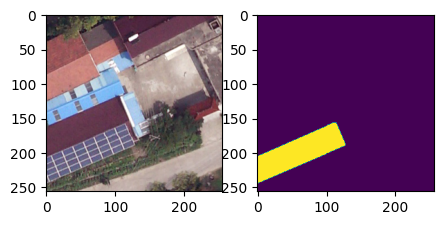

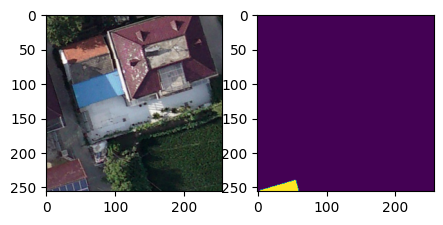

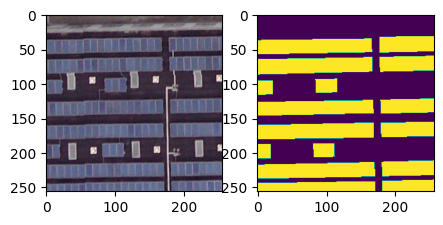

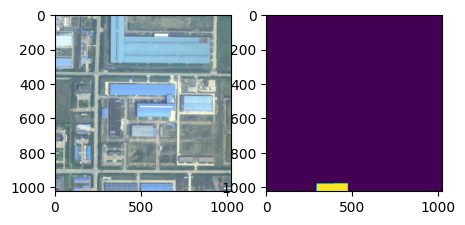

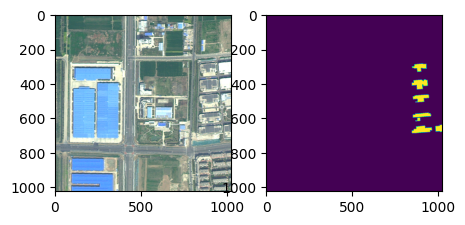

In [ ]:
plot(data[1],labels[1])
plot(data[120],labels[120])
plot(data[500],labels[500])
plot(data[-1],labels[-1])
plot(data[-5],labels[-5])

#Data Prepration

## Data Cleaning

During training some images cause errors. Those images have all zero masks or just a line in the mask which caused a degenerated box during the training of the object detection model. So here I would explore this problem.

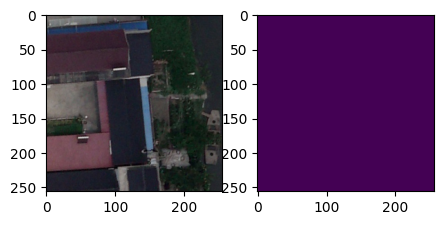

In [ ]:
plot(data[28], labels[28])

We have some pics with no panel, this will cause an error in the `masks_to_boxes` function.

In [ ]:
from torchvision.ops import masks_to_boxes

def is_degenerate(box):
  return box[0]==box[2] or box[1]==box[3]

bad_box = [i for i,l in enumerate(labels) if len(l.nonzero())==0 or is_degenerate(masks_to_boxes(l)[0])]

In [ ]:
bad_box

[28, 75, 84, 135, 399, 405, 467, 614]

So we have 8 pic with no panel. we can safely remove them.

In [ ]:
data=[d for i,d in enumerate(data) if i not in bad_box]
labels=[d for i,d in enumerate(labels) if i not in bad_box]

In [ ]:
len(data), len(labels)

(736, 736)

Is every image the same size?

In [ ]:
from collections import Counter
Counter([img.size() for img in data])

So we will resize all pics to 256*256

In [ ]:
data = [TF.resize(d, size=[256]) if d.size()[1]!=256 else d for d in data]
labels = [TF.resize(d, size=[256]) if d.size()[1]!=256 else d for d in labels]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## Normalization

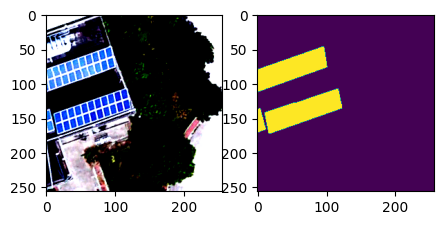

In [ ]:
from torchvision import transforms
transform = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
normalized_img = transform(data[230])
plot(normalized_img, labels[230])

In [ ]:
data=[transform(d) for d in data]

In [ ]:
%cd drive/MyDrive/Colab\ Notebooks/proactive/

/content/drive/MyDrive/Colab Notebooks/proactive


In [ ]:
!mkdir processed_data

In [ ]:
from torchvision.utils import save_image

for i,(d,l) in enumerate(zip(data,labels)):
  save_image(d,f"processed_data/{i}.bmp")
  save_image(l,f"processed_data/{i}_mask.bmp")